In [1]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

## 0. Loading input data

In [2]:
## Loading WT promoter sequence

# Promoter
lacWT = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequences
O1 = 'AATTGTGAGCGGATAACAATT'

_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv('../data/ecoli_gene_list.csv')
lacO1_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
lacO1 = tregs.seq_utils.get_regulatory_region(genome, lacO1_TSS, reverse=True)

In [3]:
## Loading and fixing the RNAP energy matrix
rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, lacWT)

## Loading and fixing the lacI energy matrix
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], O1)
O1_emat = np.mean(O1_1027_fixed, axis=0)

## 2. Calculate $p_{\mathrm{bound}}$

In [4]:
n_NS = len(genome)
n_p = 4600
n_r = 10

ep_wt = -5
er_wt = -15
df = tregs.simulate.simrep(lacO1, lacWT, O1, rnap_emat, O1_emat, 
                                ep_wt, er_wt, n_NS, n_p, n_r)
df.head()

,seq,pbound,ct_0,ct_1,ct,norm_ct_1
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.105563,19.131889,202.0,221.131889,10.558289
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.144633,24.397661,353.0,377.397661,14.468600
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.073167,4.742871,35.0,39.742871,7.379497
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.052113,0.422942,3.0,3.422942,7.093170
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.111799,6.799967,77.0,83.799967,11.323585


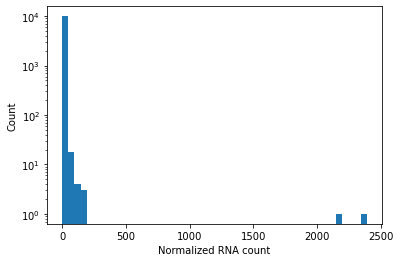

In [9]:
plt.hist(df['norm_ct_1'], bins=50)
plt.xlabel('Normalized RNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [10]:
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, lacO1, nbins, upper_bound)

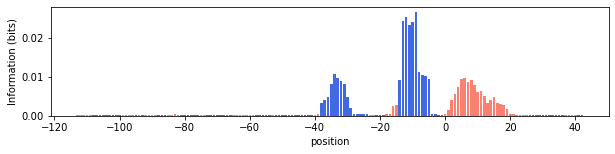

In [11]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 5
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, lacO1, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)

plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

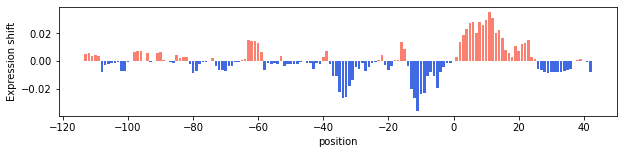

In [13]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Expression shift')
ax.set_xlabel('position')

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, exshift_list, edgecolor=None, color=shiftcolors)

plt.savefig('../figs/lacI_synthetic_exshift_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
ep_wt = -3
er_wt = -15

df = tregs.simulate.simrep(lacO1, lacWT, O1, rnap_emat, O1_emat, 
                                ep_wt, er_wt, n_NS, n_p, n_r)
df.head()

,seq,pbound,ct_0,ct_1,ct,norm_ct_1
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.008867,0.443284,1.0,1.443284,2.255891
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.002848,20.587086,6.0,26.587086,0.291445
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.006120,31.499379,20.0,51.499379,0.634933
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.002995,6.594223,2.0,8.594223,0.303296
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.003954,0.027722,1.0,1.027722,36.072204


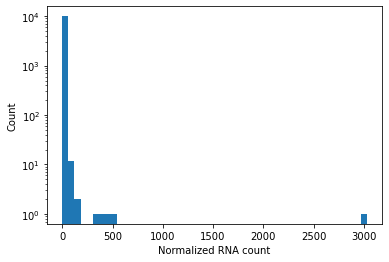

In [16]:
plt.hist(df['norm_ct_1'], bins=50)
plt.xlabel('Normalized RNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [17]:
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, lacO1, nbins, upper_bound)

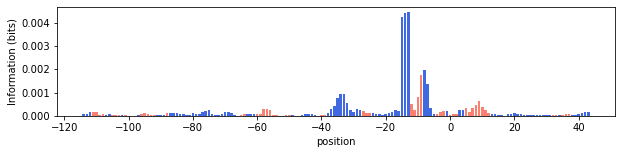

In [18]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, lacO1, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)

plt.savefig('../figs/lacI_synthetic_footprint_3_15.png', dpi=300, bbox_inches='tight')
plt.show()

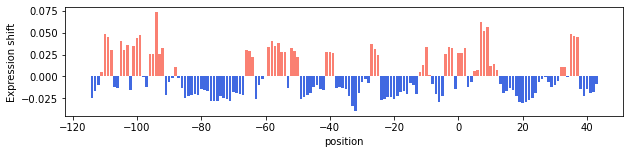

In [19]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Expression shift')
ax.set_xlabel('position')

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, exshift_list, edgecolor=None, color=shiftcolors)

plt.savefig('../figs/lacI_synthetic_exshift_3_15.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
ep_wt = -5
er_wt = -25

df = tregs.simulate.simrep(lacO1, lacWT, O1, rnap_emat, O1_emat, 
                                ep_wt, er_wt, n_NS, n_p, n_r)
df.head()

,seq,pbound,ct_0,ct_1,ct,norm_ct_1
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.014334,1.467728,3.0,4.467728,2.043976
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.001387,20.501536,3.0,23.501536,0.146331
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000039,12.697526,1.0,13.697526,0.078755
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000135,18.037538,1.0,19.037538,0.055440
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000011,1.144722,1.0,2.144722,0.873575


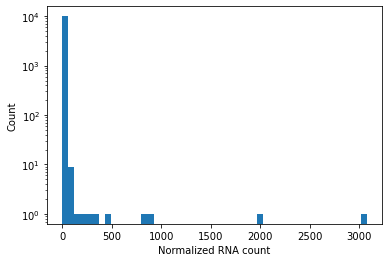

In [26]:
plt.hist(df['norm_ct_1'], bins=50)
plt.xlabel('Normalized RNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [27]:
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = 5
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, lacO1, nbins, upper_bound)

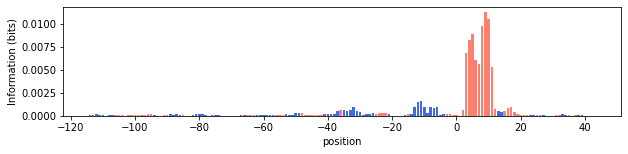

In [29]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, lacO1, smoothed=True, windowsize=windowsize)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)
ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors)

plt.savefig('../figs/lacI_synthetic_footprint_5_25.png', dpi=300, bbox_inches='tight')
plt.show()

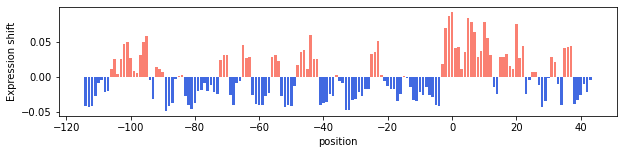

In [30]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Expression shift')
ax.set_xlabel('position')

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
ax.bar(x, exshift_list, edgecolor=None, color=shiftcolors)

plt.savefig('../figs/lacI_synthetic_exshift_5_25.png', dpi=300, bbox_inches='tight')
plt.show()